## Training RNN network on single trial data

In [201]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import mat73

import pyaldata as pyal
import pylab
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from tools.curbd import curbd
import pylab
from tools.dsp.preprocessing import preprocess

np.random.seed(44)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [202]:
data_dir = "/data/bnd-data/raw/M044/M044_2024_12_04_09_30"
mat_file = "M044_2024_12_04_09_30_pyaldata.mat"
fname = os.path.join(data_dir, mat_file)

df = pyal.mat2dataframe(fname, shift_idx_fields=True)
mouse = mat_file.split('_')[0]

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_KSLabel could not be converted to int.


### PROCESSING DATAFRAME

In [203]:
df_ = preprocess(df, only_trials=True)
df_ = pyal.select_trials(df_, "idx_trial_end > 30365")  # Remove first 5 minutes because the switch was off
df_ = pyal.select_trials(df_, "values_Sol_direction == 2")  # to test RNN training only use a subset of trials

/home/zms24/.conda/envs/zofia_earthquake_env/earthquake-analysis/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


Combined every 3 bins
Resulting all_spikes ephys data shape is (NxT): (474, 133)


In [204]:
df_.head()

,animal,session,trial_id,trial_name,trial_length,bin_size,idx_trial_start,idx_trial_end,idx_CPI,values_before_camera_trigger,...,idx_sol_on,idx_earthquake_duration,idx_session_timer,all_chan_best,all_unit_guide,all_KSLabel,all_spikes,all_rates,sol_level_id,sol_contra_ipsi
0,M044,M044_2024_12_04_09_30,92,trial,401,0.03,31399,31533,[],[],...,66,[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[19.15118, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,1
1,M044,M044_2024_12_04_09_30,126,trial,401,0.03,36699,36833,[],[],...,66,[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.91412437, 0.0, 0.034771092, 0.0, 0.0, 0.0,...",0,1
2,M044,M044_2024_12_04_09_30,144,trial,401,0.03,38933,39066,[],[],...,66,[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...","[[10.21812, 0.0, 0.0, 0.0, 0.0, 12.949476, 0.0...",0,1
3,M044,M044_2024_12_04_09_30,188,trial,401,0.03,44533,44666,[],[],...,66,[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,1
4,M044,M044_2024_12_04_09_30,198,trial,401,0.03,45566,45699,[],[],...,66,[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[21.267122, 0.0, 0.91412437, 0.0, 2.798774, 0...",0,1


In [205]:
# Separate columns of 'all_spikes' to M1 and Dls (dorsolateral striatum)
brain_areas = ["Dls", "M1"]
df_["M1_rates"] = [df_["all_rates"][i][:,300:] for i in range(len(df_))]
df_["Dls_rates"] = [df_["all_rates"][i][:,0:300] for i in range(len(df_))]

# perturbation time
perturbation_time = df_.idx_sol_on[0]
perturbation_time_seconds = perturbation_time * df_.bin_size[0]

# solenoid angles
sol_angles: list = df_.values_Sol_direction.unique()
sol_angles.sort()

# number of trials in data
num_trials = len(df_)
print(num_trials)

42


### CONCATINATE ALL TRIALS

In [206]:
df_concat_trials = pyal.concat_trials(df_, signal = "all_rates")
print(df_.all_rates[2].shape)

(133, 474)


### PLOT RNN INPUT

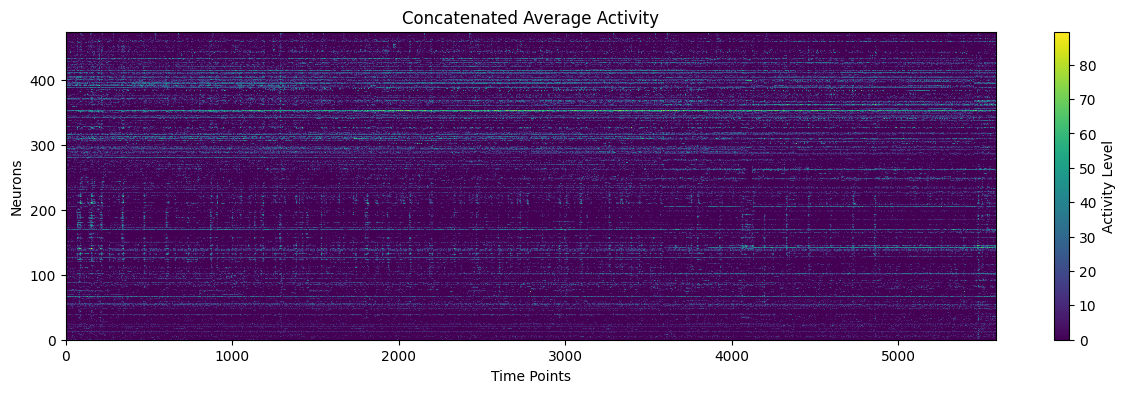

In [207]:
plt.figure(figsize=(15, 4))  # Set figure size
plt.pcolormesh(df_concat_trials.T, cmap='viridis', shading='auto')
plt.colorbar(label='Activity Level')
plt.title('Concatenated Average Activity')
plt.xlabel('Time Points')
plt.ylabel('Neurons')
plt.show()

SETTING UP VARIABLES FOR RNN

In [208]:
trial_len = df_[brain_areas[0]+"_rates"][0].shape[0]
if all(df_[col+"_rates"][0].shape[0] == trial_len for col in brain_areas):
    print(f"Trial length: {trial_len}")
else:
    print("Variable trial length!")

reset_points = []
for i in range(len(df_)):
    reset_points.append(i*trial_len)

Trial length: 133


In [209]:
activity = np.transpose(df_concat_trials)
Na = df_.Dls_rates[1].shape[1]
Nb = df_.M1_rates[1].shape[1]

regions = [['Dls', np.arange(0, Na)], ['M1', np.arange(Na, Na + Nb)]]
regions = np.array(regions, dtype=object)
print(f"Building {len(regions)} region RNN network")
print(f"Regions: {regions[:, 0]} with {Na} neurons for {regions[0,0]} and {Nb} neurons for {regions[1,0]}.\n")

Building 2 region RNN network
Regions: ['Dls' 'M1'] with 300 neurons for Dls and 174 neurons for M1.



## TRAIN RNN

In [ ]:
model = curbd.trainMultiRegionRNN(activity,
                                  dtData=df_.bin_size[0],
                                  dtFactor=1,
                                  tauRNN = 0.2,
                                  ampInWN= 0.01,
                                  g = 1.5,
                                  regions=regions,
                                  nRunTrain=50,
                                  verbose=True,
                                  plotStatus=False,
                                  nRunFree=5,
                                  resetPoints=reset_points)

trial=0 pVar=0.328760 chi2=28.843054


#### plot pVar and chi2

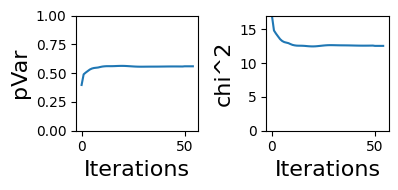

In [ ]:
fig = pylab.figure(figsize=[4, 2])

axn = fig.add_subplot(1, 2, 1)
axn.plot(model['pVars'])
axn.set_ylabel("pVar", fontsize=16)
axn.set_xlabel("Iterations", fontsize=16)
axn.set_ylim(0, 1)

axn = fig.add_subplot(1, 2, 2)
axn.plot(model['chi2s'])
axn.set_ylabel("chi^2", fontsize=16)
axn.set_xlabel("Iterations", fontsize=16)
axn.set_ylim(0, np.max(model['chi2s']))

fig.tight_layout()
fig.show()

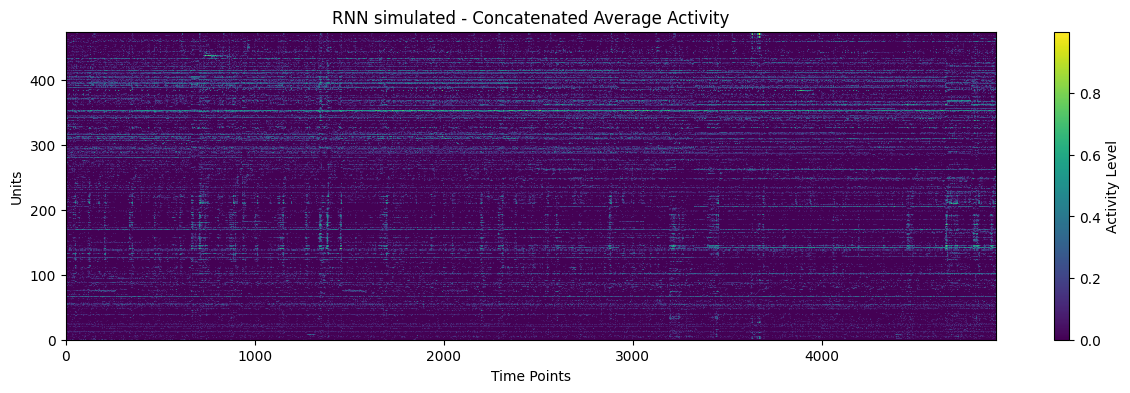

In [ ]:
plt.figure(figsize=(15, 4))  # Set figure size
plt.pcolormesh(model['Adata'], cmap='viridis', shading='auto')
plt.colorbar(label='Activity Level')
plt.title('RNN simulated - Concatenated Average Activity')
plt.xlabel('Time Points')
plt.ylabel('Units')
plt.show()

## PCA AND CCA

In [ ]:
def rescale_array(arr):
    """
    Rescales a NumPy array to the range [0, 1].

    Parameters:
        arr (numpy.ndarray): Input array.

    Returns:
        numpy.ndarray: Rescaled array.
    """
    arr_min = np.min(arr)
    arr_max = np.max(arr)

    if arr_max == arr_min:
        return np.zeros_like(arr)  # Avoid division by zero if all values are the same

    return (arr - arr_min) / (arr_max - arr_min)

def PCA_fit_transform(data, n_components):
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_

    return pca, pca_data

def CCA_compare(data_real, data_rnn, num_comp):

    # CCA between real activity and simulated
    cca = CCA(n_components=num_comp, tol=1e-4, max_iter=2000)

    cca.fit(data_real, data_rnn)
    data_c, rnn_c = cca.transform(data_real, data_rnn)

    score = cca.score(data_real, data_rnn)

    # control CCA
    cca_ctrl_real = CCA(n_components=num_comp)
    cca_ctrl_real.fit(data_real, data_real)
    data_c_ctrl_real, rnn_c_ctrl_real = cca_ctrl_real.transform(data_real, data_real)

    cca_ctrl_rnn = CCA(n_components=num_comp)
    cca_ctrl_rnn.fit(data_rnn, data_rnn)
    data_c_ctrl_rnn, rnn_c_ctrl_rnn = cca_ctrl_rnn.transform(data_rnn, data_rnn)

    score_ctrl_real = cca_ctrl_real.score(data_real, data_real)
    score_ctrl_rnn = cca_ctrl_rnn.score(data_rnn, data_rnn)

    canonical_values = [[data_c, rnn_c], [data_c_ctrl_real, rnn_c_ctrl_real], [data_c_ctrl_rnn, rnn_c_ctrl_rnn]]
    scores = [score, score_ctrl_real, score_ctrl_rnn]

    return canonical_values, scores

def plot_3PCs(fig, data, subplot_num, title):
    ax1 = fig.add_subplot(subplot_num, projection='3d', aspect='equal')

    # Plot all single trial trajectories in light grey
    for trial in range(data.shape[0]):
        ax1.plot(data[trial, :, 0],
                 data[trial, :, 1],
                 data[trial, :, 2], color='lightgrey', alpha=0.7)

    # Compute and plot the averaged trajectory in bold color
    avg_trajectory = np.mean(data, axis=0)
    ax1.plot(avg_trajectory[:, 0], avg_trajectory[:, 1], avg_trajectory[:, 2], 
             color='red', linewidth=3, label='Average Trajectory')

    ax1.set_title(title)
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    ax1.legend(loc='upper left')

def plot_PCA(real_data, rnn_data, trial_num, mouse_num):
    reconstructed_data_avg = np.split(real_data, trial_num)
    reconstructed_rnn = np.split(rnn_data, trial_num)
    reconstructed_data_avg = np.array(reconstructed_data_avg)
    reconstructed_rnn = np.array(reconstructed_rnn)

    fig = plt.figure(figsize=(20, 10))

    plot_3PCs(fig, reconstructed_data_avg, 121, 'Recorded data')
    plot_3PCs(fig, reconstructed_rnn, 122, 'RNN simulated data')
    
    plt.suptitle(f'First 3PCs plot comparison - mouse {mouse_num}', fontsize=16)
    plt.tight_layout()
    plt.show()
    return fig

def plot_CCA(data_cs, rnn_cs, labels, num_comp, mouse_num):
    fig = plt.figure(figsize=(6, 4))
    for data_c, rnn_c, label in zip(data_cs, rnn_cs, labels):
        corrs = [np.corrcoef(data_c[:, i], rnn_c[:, i])[0, 1] for i in range(num_comp)]
        plt.plot(corrs, label=label)
    plt.xlabel('canonical coefficient index')
    plt.ylabel('CCA correlation')
    plt.title(f"CCA analysis results - mouse {mouse_num}")
    plt.legend()
    plt.show()

    return fig

def plot_PCA_cum_var(pca_real, pca_rnn, mouse_num):
    fig = plt.figure(figsize=(6, 4))
    plt.plot(np.cumsum(pca_real.explained_variance_ratio_), label='real activity')
    plt.plot(np.cumsum(pca_rnn.explained_variance_ratio_), label='RNN activity')

    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'Cumulative Variance Explained by PCA - mouse {mouse_num}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return fig

    def plot_3PCs(fig, data, subplot_num, title):
        ax1 = fig.add_subplot(subplot_num, projection='3d', aspect='equal')
        for trial in range(data.shape[0]):
            ax1.plot(data[trial, :, 0],
                     data[trial, :, 1],
                     data[trial, :, 2], label=f'Trial {trial + 1}')
        ax1.set_title(title)
        ax1.set_xlabel('PC1')
        ax1.set_ylabel('PC2')
        ax1.set_zlabel('PC3')
        ax1.legend(loc='upper left')

In [ ]:
def PCA_and_CCA(concat_rates, rnn_model, num_components, trial_num, mouse_num, printing=True):
    data_rnn = rnn_model['Adata'].T
    data_real = rescale_array(concat_rates)

    # PCA
    pca_real, pca_data_real = PCA_fit_transform(data_real, num_components)
    pca_rnn, pca_data_rnn = PCA_fit_transform(data_rnn, num_components)

    variance_figure = plot_PCA_cum_var(pca_real, pca_rnn, mouse_num)
    PCA_figure = plot_PCA(pca_data_real, pca_data_rnn, trial_num, mouse_num)

    # CCA
    canonical_values, scores = CCA_compare(pca_data_real, pca_data_rnn, num_components)
    canonical_values = np.array(canonical_values)

    if printing:
        print(f"CCA score of real data and RNN data aligment: {scores[0]}")
        print(f"CCA score for control on real data: {scores[1]}")
        print(f"CCA score for control on rnn data: {scores[2]}")

    CCA_figure = plot_CCA(canonical_values[:, 0], canonical_values[:, 1],
                          ['Real & RNN data', 'Control - Real data', 'Control - RNN data'], num_components, mouse_num)

    return scores, variance_figure, PCA_figure, CCA_figure

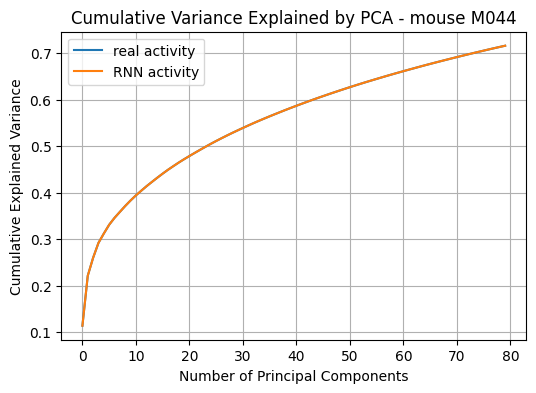

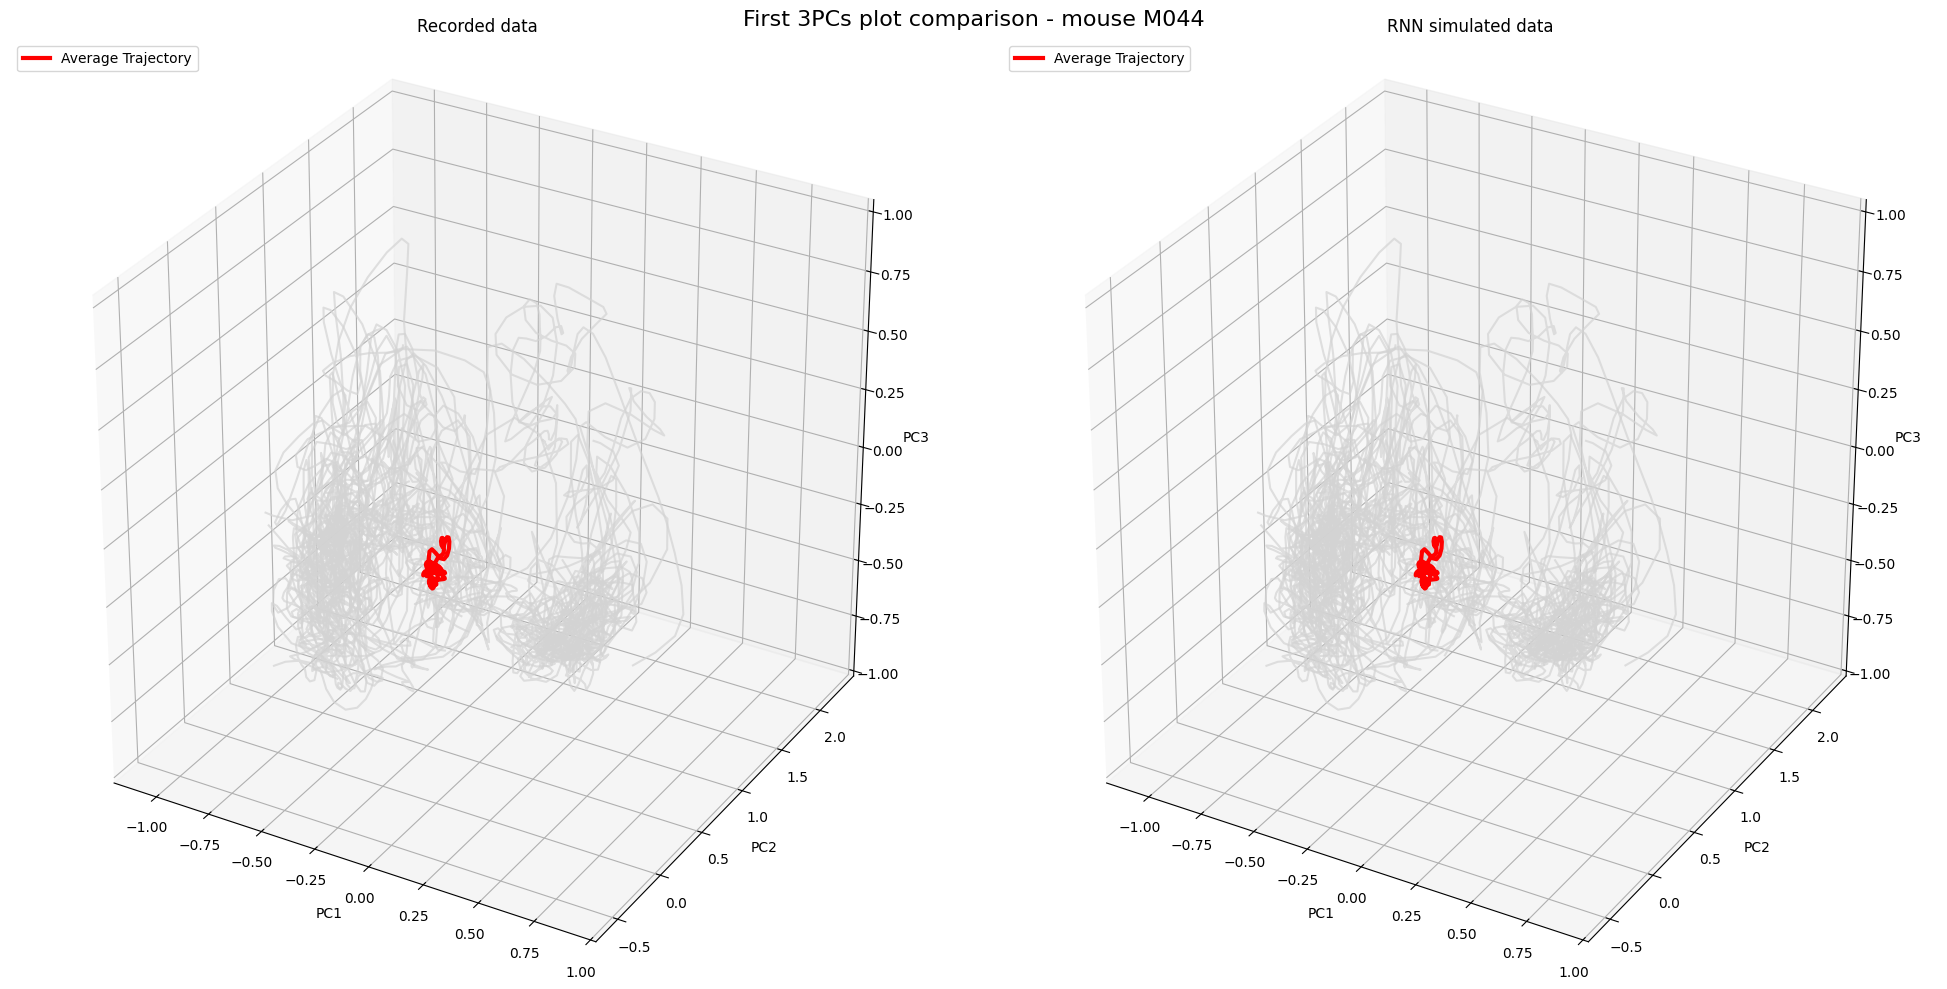

CCA score of real data and RNN data aligment: 0.9999999805588875
CCA score for control on real data: 0.9999999999999994
CCA score for control on rnn data: 0.9999999999999993


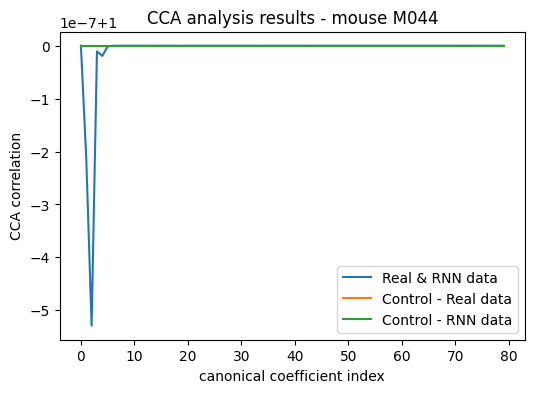

In [ ]:
scores, variance_figure, PCA_figure, CCA_figure = PCA_and_CCA(df_concat_trials, model, num_components = 80, trial_num = num_trials, mouse_num = mouse, printing=True)

## CURBD

plot currents (code from the test_CURBD.ipynb)

In [ ]:
curbd_arr, curbd_labels = curbd.computeCURBD(model)

In [ ]:
n_regions = curbd_arr.shape[0]

currents1_fig = pylab.figure(figsize=[8, 8])
count = 1
for iTarget in range(n_regions):
    for iSource in range(n_regions):
        axn = fig.add_subplot(n_regions, n_regions, count)
        count += 1
        n_region_units = curbd_arr[iTarget, iSource].shape[0]
        print("x: ", model['tRNN'].shape, "y: ", len(range(n_region_units)), "C: ", curbd_arr[iTarget, iSource].shape, "\n")
        axn.pcolormesh(model['tRNN'], range(n_region_units),
                       curbd_arr[iTarget, iSource]) # time x neurons
        axn.set_xlabel('Time (s)')
        axn.set_ylabel('Neurons in {}'.format(regions[iTarget, 0]))
        axn.set_title(curbd_labels[iTarget, iSource])
        axn.title.set_fontsize(8)
        axn.xaxis.label.set_fontsize(8)
        axn.yaxis.label.set_fontsize(8)
currents1_fig.subplots_adjust(hspace=0.4, wspace=0.3)
currents1_fig.show()

x:  (4921,) y:  300 C:  (300, 4921) 

x:  (4921,) y:  300 C:  (300, 4921) 

x:  (4921,) y:  174 C:  (174, 4921) 

x:  (4921,) y:  174 C:  (174, 4921) 



<Figure size 800x800 with 0 Axes>

In [ ]:

currents2_fig = pylab.figure(figsize=[8, 8])
count = 1
for iTarget in range(n_regions):
    for iSource in range(n_regions):
        axn = fig.add_subplot(n_regions, n_regions, count)
        count += 1
        axn.plot(model['tRNN'], curbd_arr[iTarget, iSource].mean(axis = 0))
        axn.set_xlabel('Time (s)')
        axn.set_ylabel('Mean region activity')
        axn.set_title(curbd_labels[iTarget, iSource])
        axn.title.set_fontsize(8)
        axn.xaxis.label.set_fontsize(8)
        axn.yaxis.label.set_fontsize(8)
currents2_fig.subplots_adjust(hspace=0.4, wspace=0.3)
currents2_fig.show()

<Figure size 800x800 with 0 Axes>

### Plot trial averaged current changes - all trials

In [ ]:
# def split_currents_by_trial_types(model, df, current_arr, current_labels, num_trials, categories):

#     regions = {label: [] for label in current_labels}
#     trial_sorted = {cat: [regions, regions, regions, regions] for cat in categories}

#     for iTarget in range(n_regions):
#         for iSource in range(n_regions):
#             arr = current_arr[iTarget][iSource]
#             label = current_labels[iTarget][iSource]
#             trial_arr = np.array(np.split(arr, num_trials))
#             if not (trial_arr.shape[0] == num_trials):
#                 print("error!")
#             for index in range(trial_arr.shape[0]):
#                 solenoid_idx = df.loc[index].values_Sol_direction
#                 trial_sorted[solenoid_idx][label].append(trial_arr[index, :, :])

#     return trial_sorted


# trials_sorted_currents = split_currents_by_trial_types(model, df, curbd_arr, curbd_labels, num_trials, sol_angles)           

### Plot trial averaged current changes - only one trial types

In [ ]:
# set up variables for plotting

dtFactor = model['params']['dtFactor']
count = 1
all_currents = []
for iTarget in range(n_regions):
    for iSource in range(n_regions):
        num_neurons = curbd_arr[iTarget, iSource].shape[0]
        arr = np.reshape(curbd_arr[iTarget, iSource], (num_neurons , num_trials, trial_len))
        all_currents.append(arr)

all_currents_labels = curbd_labels.flatten()

In [ ]:
trial_currents_fig = pylab.figure(figsize=[12, 8])
count = 1

for i in range(len(all_currents)):

    current_data = all_currents[i]
    current_label = all_currents_labels[i]
    time_axis = np.linspace(0, current_data.shape[2] * df_.bin_size[0], current_data.shape[2])

    axn = fig.add_subplot(2, 2, count)
    count += 1

    # plotting each trial current
    for trial_index in range(num_trials):
        arr = current_data[:, trial_index, :]
        trial_mean = np.mean(arr, axis = 0)
        axn.plot(time_axis, trial_mean, color='lightblue', linewidth=0.5)

    # plotting mean current for trial
    mean_current = np.mean(current_data, axis=(0, 1))
    
    axn.plot(time_axis, mean_current, color='steelblue', linewidth=2)

    axn.axvline(perturbation_time_seconds, color='red', linestyle='--', linewidth=1, label = 'Perturbation time')

    axn.set_title(f'{current_label} currents')
    axn.set_xlabel('Time (s)')
    axn.set_ylabel('Average Activity')
    axn.title.set_fontsize(16)
    axn.xaxis.label.set_fontsize(16)
    axn.yaxis.label.set_fontsize(16)
    
trial_currents_fig.subplots_adjust(hspace=0.4, wspace=0.3)
trial_currents_fig.show() 

<Figure size 1200x800 with 0 Axes>

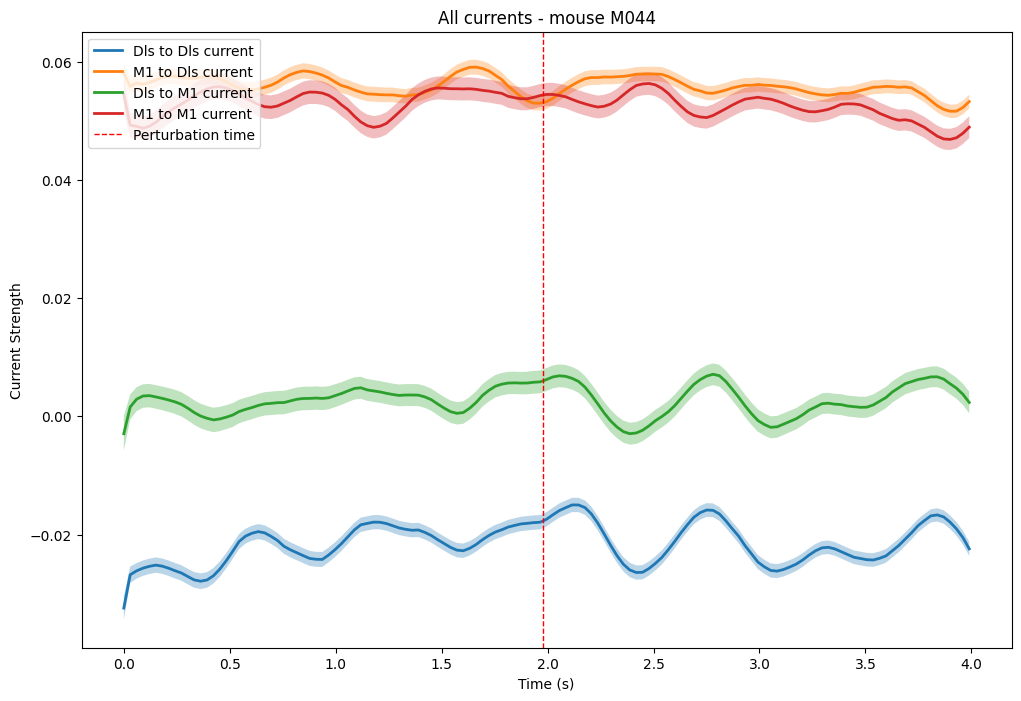

In [ ]:
all_currents_fig = pylab.figure(figsize=[12, 8])

for i in range(len(all_currents)):

    current_data = all_currents[i]
    current_label = all_currents_labels[i]
    time_axis = np.linspace(0, current_data.shape[2] * df_.bin_size[0], current_data.shape[2])

    # plotting each trial current
    for trial_index in range(num_trials):
        arr = current_data[:, trial_index, :]
        trial_mean = np.mean(arr, axis = 0)
        axn.plot(time_axis, trial_mean, color='lightblue', linewidth=0.5)
    
    # plotting mean current for trial
    mean_current = np.mean(current_data, axis=(0, 1))
    sem_current = np.std(current_data, axis=(0, 1)) / np.sqrt(current_data.shape[0] * current_data.shape[1])
    
    pylab.plot(time_axis, mean_current, linewidth=2, label=f'{current_label} current')
    pylab.fill_between(time_axis, mean_current - sem_current, mean_current + sem_current, alpha=0.3)

    axn.axvline(perturbation_time_seconds, color='red', linestyle='--', linewidth=1, label = 'Perturbation time')

# Add a red vertical line at time 0
pylab.axvline(perturbation_time_seconds, color='red', linestyle='--', linewidth=1, label='Perturbation time')
# Set labels and title
pylab.title('All currents - mouse M044')
pylab.xlabel('Time (s)')
pylab.ylabel('Current Strength')
pylab.legend(loc='upper left')
pylab.show()


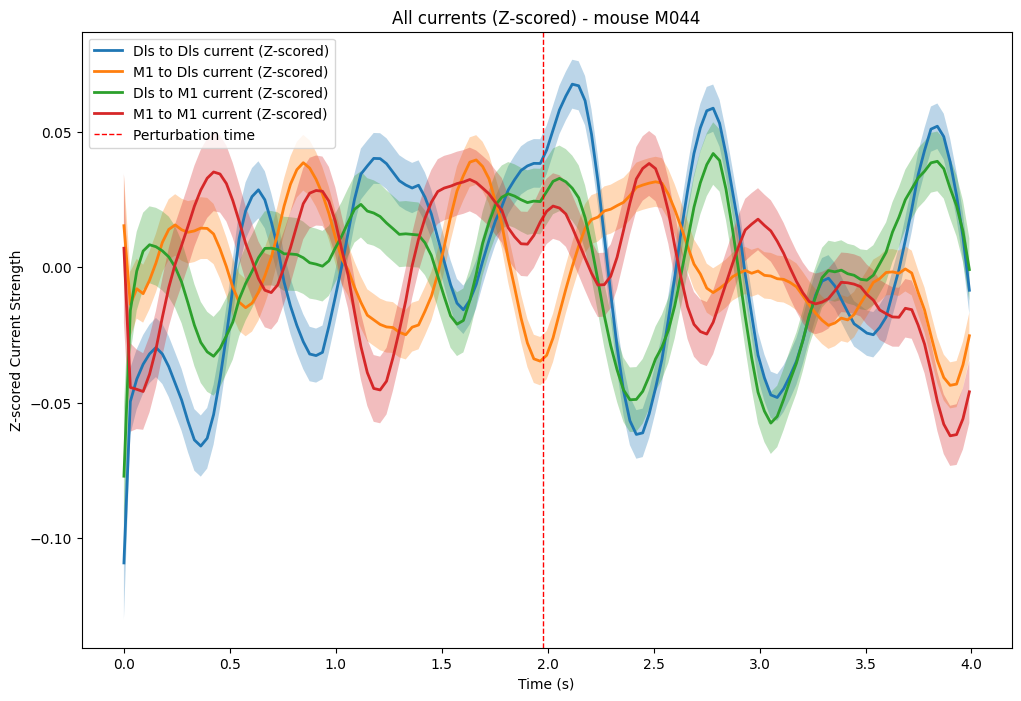

In [ ]:
all_currents_zscore_fig = pylab.figure(figsize=[12, 8])

for i in range(len(all_currents)):

    current_data = all_currents[i]
    current_label = all_currents_labels[i]
    
    # Compute Z-scored data
    mean_across_trials = np.mean(current_data, axis=(1, 2), keepdims=True)  # Mean across trials and time
    std_across_trials = np.std(current_data, axis=(1, 2), keepdims=True)    # Std across trials and time
    zscored_data = (current_data - mean_across_trials) / (std_across_trials + 1e-8)  # Avoid division by zero

    time_axis = np.linspace(0, current_data.shape[2] * df_.bin_size[0], current_data.shape[2])

    # Plot each trial's Z-scored current
    for trial_index in range(num_trials):
        arr = zscored_data[:, trial_index, :]
        trial_mean = np.mean(arr, axis=0)
        axn.plot(time_axis, trial_mean, color='lightblue', linewidth=0.5)

    # Compute mean and SEM of Z-scored data
    mean_current = np.mean(zscored_data, axis=(0, 1))
    sem_current = np.std(zscored_data, axis=(0, 1)) / np.sqrt(zscored_data.shape[0] * zscored_data.shape[1])
    
    pylab.plot(time_axis, mean_current, linewidth=2, label=f'{current_label} current (Z-scored)')
    pylab.fill_between(time_axis, mean_current - sem_current, mean_current + sem_current, alpha=0.3)

    axn.axvline(perturbation_time_seconds, color='red', linestyle='--', linewidth=1, label='Perturbation time')

# Add a red vertical line at perturbation time
pylab.axvline(perturbation_time_seconds, color='red', linestyle='--', linewidth=1, label='Perturbation time')

# Set labels and title
pylab.title('All currents (Z-scored) - mouse M044')
pylab.xlabel('Time (s)')
pylab.ylabel('Z-scored Current Strength')
pylab.legend(loc='upper left')
pylab.show()


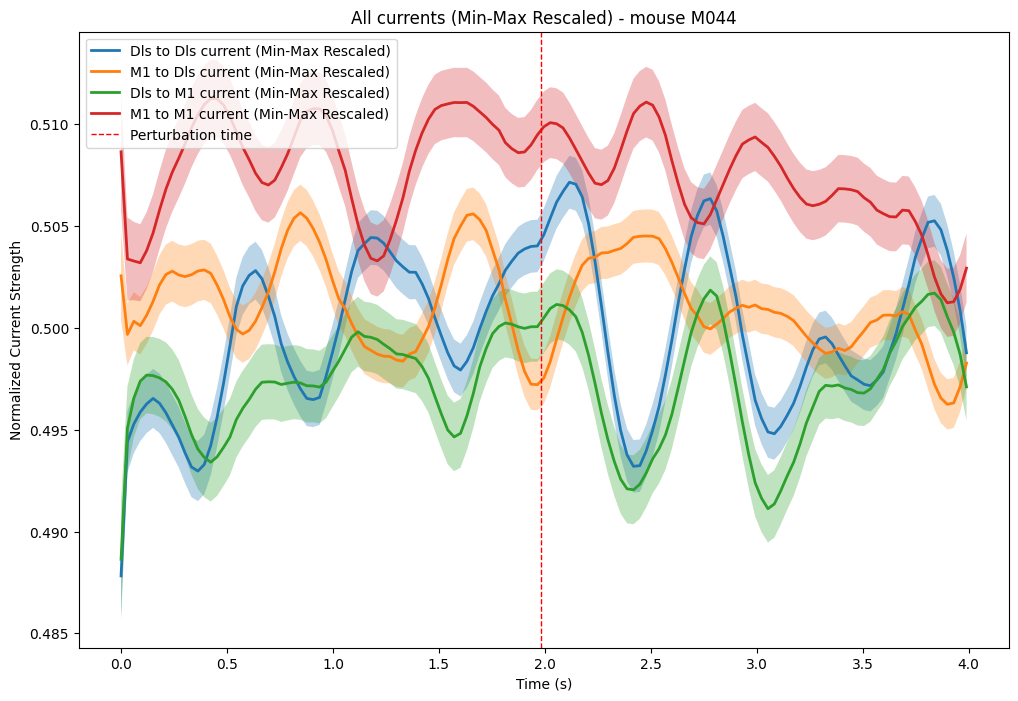

In [ ]:
all_currents_minmax_fig = pylab.figure(figsize=[12, 8])

for i in range(len(all_currents)):

    current_data = all_currents[i]
    current_label = all_currents_labels[i]
    
    # Compute min and max across trials and time for each channel
    min_across_trials = np.min(current_data, axis=(1, 2), keepdims=True)
    max_across_trials = np.max(current_data, axis=(1, 2), keepdims=True)
    
    # Apply Min-Max scaling (avoid division by zero)
    min_max_scaled_data = (current_data - min_across_trials) / (max_across_trials - min_across_trials + 1e-8)

    time_axis = np.linspace(0, current_data.shape[2] * df_.bin_size[0], current_data.shape[2])

    # Plot each trial's min-max rescaled current
    for trial_index in range(num_trials):
        arr = min_max_scaled_data[:, trial_index, :]
        trial_mean = np.mean(arr, axis=0)
        axn.plot(time_axis, trial_mean, color='lightblue', linewidth=0.5)

    # Compute mean and SEM of rescaled data
    mean_current = np.mean(min_max_scaled_data, axis=(0, 1))
    sem_current = np.std(min_max_scaled_data, axis=(0, 1)) / np.sqrt(min_max_scaled_data.shape[0] * min_max_scaled_data.shape[1])
    
    pylab.plot(time_axis, mean_current, linewidth=2, label=f'{current_label} current (Min-Max Rescaled)')
    pylab.fill_between(time_axis, mean_current - sem_current, mean_current + sem_current, alpha=0.3)

    axn.axvline(perturbation_time_seconds, color='red', linestyle='--', linewidth=1, label='Perturbation time')

# Add a red vertical line at perturbation time
pylab.axvline(perturbation_time_seconds, color='red', linestyle='--', linewidth=1, label='Perturbation time')

# Set labels and title
pylab.title('All currents (Min-Max Rescaled) - mouse M044')
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized Current Strength')
pylab.legend(loc='upper left')
pylab.show()


In [ ]:
def save_plot(figures, filenames, folder_name, base_dir):
    """
    Saves the given figure to a new folder with a unique name for each run.

    Parameters:
        figures list of (matplotlib.figure.Figure): The figure to save.
        folder_name (str): Name of the folder to be created
        base_dir (str): The base directory to store all plot folders.

    Returns:
        str: The path where the figure was saved.
    """
    run_folder = os.path.join(base_dir, folder_name)
    os.makedirs(run_folder, exist_ok=True)
    file_paths = []

    for i in range(len(figures)):
        fig = figures[i]
        file_path = os.path.join(run_folder, f"{filenames[i]}.png")
        file_paths.append(file_path)
        fig.savefig(file_path, dpi=300)
        plt.close(fig)

    return file_paths

def save_results(data_dir, figures, plot_filenames, printing=True):
    model_name = f"solenoid level number {df_.values_Sol_direction[0]}"
    
    graph_dir = os.path.join(data_dir, "single_trial_rnn_graphs/")
    folder_name = f'{model_name}'

    file_path = save_plot(figures, plot_filenames, folder_name, base_dir=graph_dir)
    if printing:
        print(file_path)


In [ ]:
graph_dir = "/home/zms24/Desktop/"
figures = [CCA_figure, PCA_figure, variance_figure, currents1_fig, currents2_fig, all_currents_fig, all_currents_minmax_fig, trial_currents_fig, all_currents_zscore_fig]
filenames = ["CCA_figure", "PCA_figure", "variance_figure", "currents1_fig", "currents2_fig", "all_currents_fig", "all_currents_minmax_fig", "trial_currents_fig", "all_currents_zscore_fig"]
save_results(graph_dir, figures, filenames)

['/home/zms24/Desktop/single_trial_rnn_graphs/solenoid level number 1/CCA_figure.png', '/home/zms24/Desktop/single_trial_rnn_graphs/solenoid level number 1/PCA_figure.png', '/home/zms24/Desktop/single_trial_rnn_graphs/solenoid level number 1/variance_figure.png', '/home/zms24/Desktop/single_trial_rnn_graphs/solenoid level number 1/currents1_fig.png', '/home/zms24/Desktop/single_trial_rnn_graphs/solenoid level number 1/currents2_fig.png', '/home/zms24/Desktop/single_trial_rnn_graphs/solenoid level number 1/all_currents_fig.png', '/home/zms24/Desktop/single_trial_rnn_graphs/solenoid level number 1/all_currents_minmax_fig.png', '/home/zms24/Desktop/single_trial_rnn_graphs/solenoid level number 1/trial_currents_fig.png', '/home/zms24/Desktop/single_trial_rnn_graphs/solenoid level number 1/all_currents_zscore_fig.png']
